In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Image
image = cv2.imread('trial_images/wr2.jpg', 0)  # Grayscale image

# 1. Denoising (Gaussian Blur + Non-Local Means)
image_denoised = cv2.fastNlMeansDenoising(image, h=10)

# 2. Sharpening
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(image, -1, kernel)

# 3. Edge Detection (Canny)
edges = cv2.Canny(image, 20, 100)
# more edges detecrion techniques
# sobel
sobelx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=5)
sobely = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

# laplacian
laplacian = cv2.Laplacian(image, cv2.CV_64F)




# 4. Thresholding
_, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# 5. Segmentation (Watershed)
def segment_watershed(img):
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1]
    markers += 1
    markers[unknown == 255] = 0
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_color, markers)
    img_color[markers == -1] = [0, 255, 0]
    return img_color

segmented = segment_watershed(image)

# 6. Contour Detection
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv2.drawContours(image_contours, contours, -1, (0, 0, 255), 2)

# 7. Histogram Equalization (Contrast Enhancement)
# equalized = cv2.equalizeHist(image)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(image)

# 8. Gaussian Blur (Smoothing)
gaussian = cv2.GaussianBlur(image, (5, 5), 0)

# 9. Morphological Operations
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(thresholded, kernel, iterations=1)
eroded = cv2.erode(thresholded, kernel, iterations=1)

# new_image = 




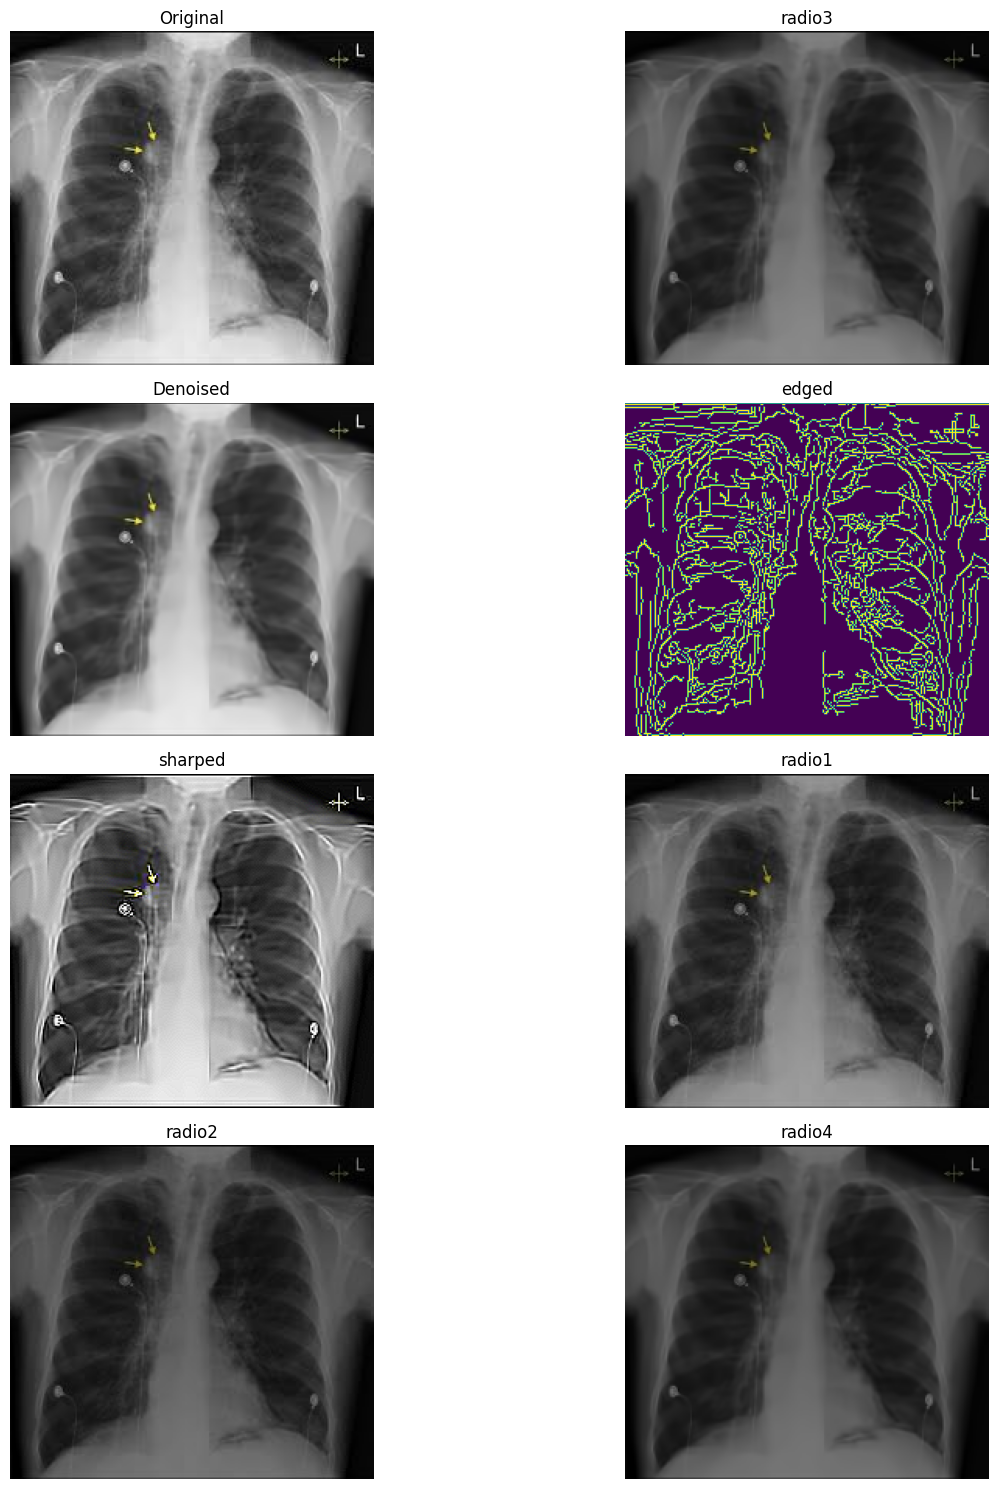

In [ ]:
# trying bm3d and radiometric calibration

from bm3d import bm3d
import cv2
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import matplotlib.pyplot as plt
import numpy as np

def image_sharpening(image , kernel = np.array([[0, -2, 0],[-2, 8, -1],[0, -2, 0]])):
    image = cv2.filter2D(image, -1, kernel)
    return image

def image_edges(image, type):
    # best == canny
    if(type == 'canny'):
        image = cv2.Canny(image, 20, 100)
    elif(type == 'sobel'):
        image = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    elif(type == 'laplacian'):
        image = cv2.Laplacian(image, cv2.CV_64F)
    return image

def radiometric_calibration(image, gain):
    image_corrected = image / gain
    return np.clip(image_corrected, 0, 255).astype(np.uint8)

# Load Image
image = cv2.imread('trial_images/lung.jpg', 1)  # Color image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 1. Denoising (BM3D)
image_denoised = bm3d(image, sigma_psd=7)

# Clip values between 0 and 255
image_denoised = np.clip(image_denoised, 0, 255)

# Convert back to uint8 for display
image_denoised = image_denoised.astype(np.uint8)



edged = image_edges(image, 'canny')

sharped = image_sharpening(image_denoised)

radio1 = radiometric_calibration(image, 1.5)
radio2 = radiometric_calibration(image, 2)
radio3 = radiometric_calibration(image_denoised, 1.7)
radio4 = radiometric_calibration(image_denoised, 2)

# Plot All Results
images = [image, radio3, image_denoised, edged,  sharped, radio1, radio2, radio4]
titles = ['Original', 'radio3','Denoised','edged', 'sharped', 'radio1', 'radio2', 'radio4']

plt.figure(figsize=(15, 15))
for i in range(len(images)):
    plt.subplot(4, 2, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

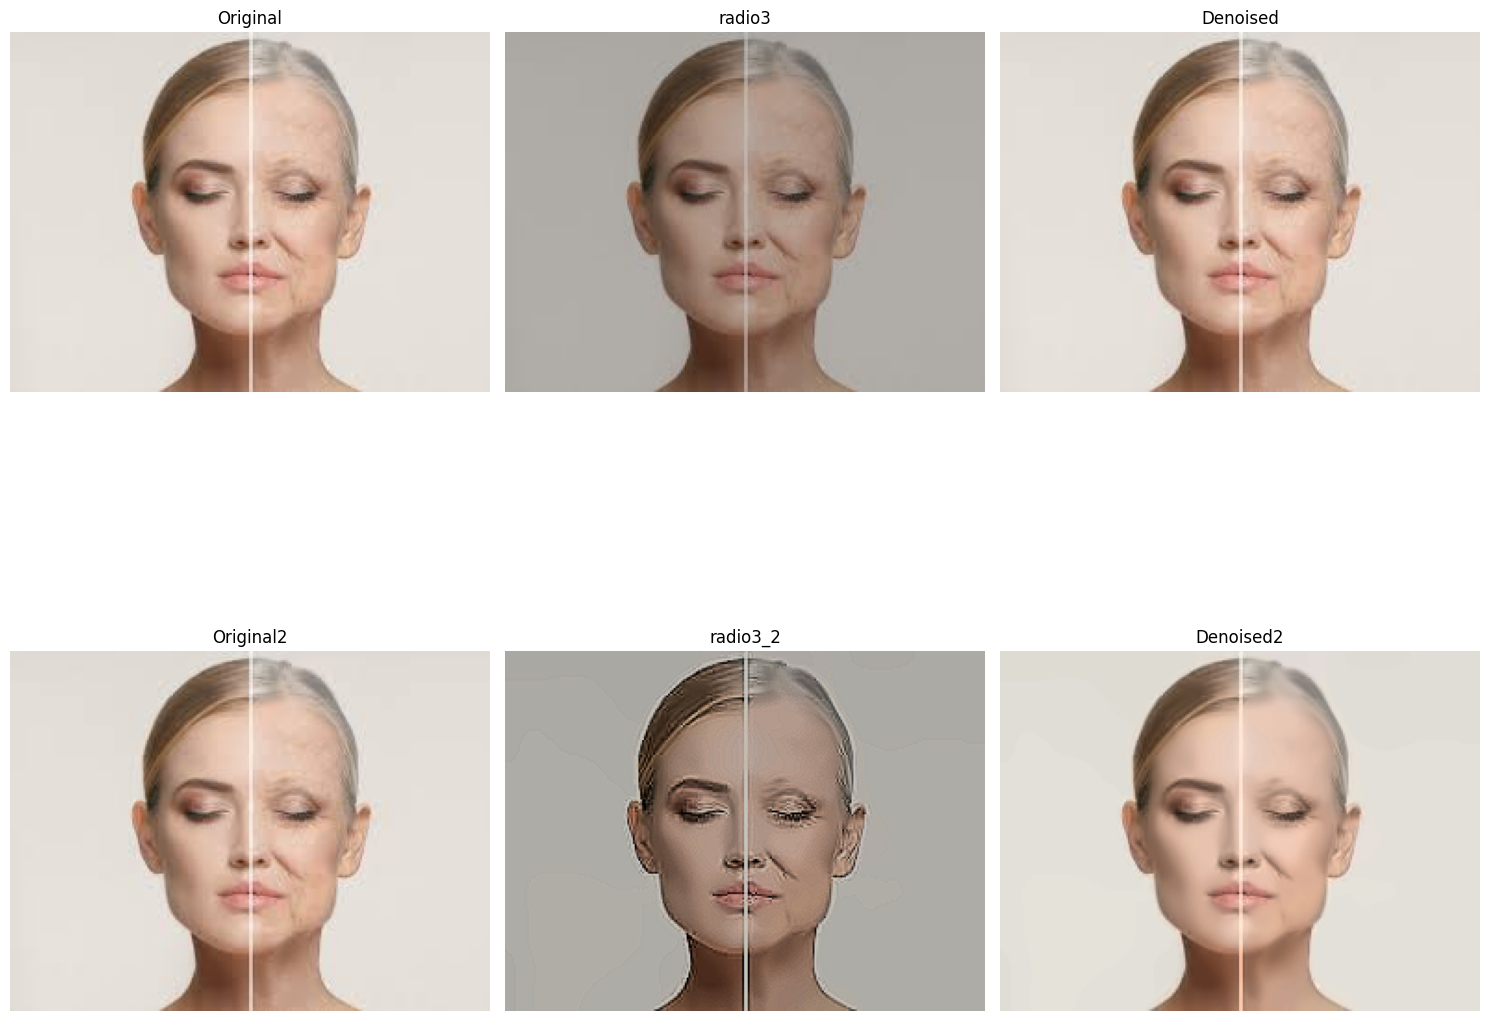

In [ ]:
# comparing denoising techniques and adjusting edge detection parameters

from bm3d import bm3d
import cv2
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import matplotlib.pyplot as plt
import numpy as np

def image_sharpening(image , kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])):
    image = cv2.filter2D(image, -1, kernel)
    return image

def radiometric_calibration(image, gain):
    image_corrected = image / gain
    return np.clip(image_corrected, 0, 255).astype(np.uint8)

# Load Image
image = cv2.imread('trial_images/wr2.jpg', 1)  # Color image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image_denoised = image

# Clip values between 0 and 255
image_denoised = np.clip(image_denoised, 0, 255)

# Convert back to uint8 for display
image_denoised = image_denoised.astype(np.uint8)


def image_segmentation(img):
    # Step 1: Apply Gaussian Blur (Optional - to smooth the image)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Step 2: Convert Image to HSV (Hue, Saturation, Value) Space for Better Color Separation
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # Step 3: Perform Otsu Thresholding on Saturation Channel (S) to Get Foreground
    _, thresh = cv2.threshold(hsv[:, :, 1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 4: Noise Removal with Morphological Opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 5: Sure Background Area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Step 6: Distance Transform to Identify Foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Step 7: Unknown Region (Background - Foreground)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 8: Label Markers for Watershed
    markers = cv2.connectedComponents(sure_fg)[1]
    markers += 1
    markers[unknown == 255] = 0

    # Step 9: Watershed
    img_watershed = img.copy()
    cv2.watershed(img_watershed, markers)
    img_watershed[markers == -1] = [0, 255, 0]  # Green boundary for segments

    return img_watershed

radio1 = radiometric_calibration(image, 1.5)
radio2 = radiometric_calibration(image, 2)
radio3 = radiometric_calibration(image_denoised, 1.3)
radio4 = radiometric_calibration(image_denoised, 2)

image_denoised2 = cv2.fastNlMeansDenoisingColored(image, None, 3, 3, 7, 21)
sharped = image_sharpening(image_denoised2)
# sharped = image_segmentation(sharped)
# sharped = cv2.Canny(sharped, 200, 400)
radio3_2 = radiometric_calibration(sharped, 1.3)

# Plot All Results
images = [image, radio3, image_denoised, image, radio3_2, image_denoised2]
titles = ['Original', 'radio3','Denoised','Original2', 'radio3_2','Denoised2']

plt.figure(figsize=(15, 15))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# pipelining
import cv2
from src.DIPutils import compress_image, image_denoising, image_sharpening, radiometric_calibration

image = cv2.imread('trial_images/kid2.jpg', 1)
def pipeline(image):
    img = compress_image(image)
    img = image_denoising(img)
    img = image_sharpening(img)
    img = radiometric_calibration(img)
    return img

# save the image
img = pipeline(image)
cv2.imwrite(r'ppt/radio.jpg', img)

True

In [2]:
from transformers import AutoModelForImageClassification


In [4]:
# i want to see the progress of model downloading
from tqdm import tqdm


In [5]:
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224")


c:\Users\parth\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\parth\.cache\huggingface\hub\models--facebook--convnext-tiny-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
model.save_pretrained('model.h5')

In [9]:
from src.visual_transformer import ConvNeXtViT
model = ConvNeXtViT(input_shape=(224, 224, 3), num_classes=2)
print(model)

ConvNeXtViT(
  (convnext): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Co

c:\Users\parth\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\parth\.cache\huggingface\hub\models--timm--convnext_tiny.in12k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
import cv2
from src.DIPutils import DIPTransform


In [5]:
from torchvision import datasets, transforms


In [6]:
i = cv2.imread(r"C:\Users\parth\Downloads\Kindey-Stone-Dataset\Kindey-Stone-Dataset\Augmented\Stone\P195_RA_F_S_I19_EL.jpg")
i3 = DIPTransform(i)

In [7]:
transforms.ToPILImage(i3)

ToPILImage(mode=<src.DIPutils.DIPTransform object at 0x0000018B49A2A990>)

In [11]:
import torch
from torchvision import transforms
from src.visual_transformer import ConvNeXtViT
import os
import cv2
from PIL import Image

In [22]:
def load_pretrained_model(model_path="src/model20.pth"):
    """Load the pre-trained model."""
    net = ConvNeXtViT(input_shape=(224, 224, 3), num_classes=2)
    if os.path.exists(model_path):
        state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        net.load_state_dict(state_dict)
    net.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    net.eval()  # Set to evaluation mode here
    return net

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),          # Convert to tensor
])

def predict_image(image_path=r"C:\Users\parth\Downloads\Kindey-Stone-Dataset\Kindey-Stone-Dataset\Augmented\Stone\P196_RA_F_S_I02_EL.jpg", model=None):
    """Predict the class of an image."""
    if model is None:
        model = load_pretrained_model()
    
    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)
    image_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension
    
    # Move to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    if predicted.item() == 0:
        print("Predicted: Non-Stone")
    else:
        print("Predicted: Stone")

In [23]:
prediction = predict_image()

Predicted: Stone


C:\Users\parth\AppData\Local\Temp\ipykernel_23608\1158816225.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devic